In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
class GetDataFrame:
    EQUIPMENT_LIST = ("CW500Viewer", "equip2")

    def __init__(self, equip_model: str, file_path: str):
        if equip_model not in self.EQUIPMENT_LIST:
            raise ValueError(f"equip_model must be one of {self.EQUIPMENT_LIST}. Got: {equip_model}")

        self.equip_model = equip_model
        self.file_path = file_path
        self.df = None  

    def load(self) -> pd.DataFrame:
        if self.equip_model == "CW500Viewer":
            self.df = self._get_and_clean_cw500_df()
            return self.df
            
        elif self.equip_model == "equip2":
            self.df = self._get_and_clean_equip2_df()
            return self.df
  
        raise ValueError(f"Unsupported equip_model: {self.equip_model}")

    def _get_and_clean_cw500_df(self) -> pd.DataFrame:
        df = pd.read_csv(self.file_path, sep=';', decimal=',', skiprows=37)

        rename_map = {  'Pst1(1min)[]': 'Pst1(1min)', 'Pst2(1min)[]': 'Pst2(1min)', 'Pst3(1min)[]': 'Pst3(1min)',
                        'Pst1[]': 'Pst1', 'Pst2[]': 'Pst2', 'Pst3[]': 'Pst3'}
        df = df.rename(columns=rename_map)
        
        cols = ['DateTime', 'Pst1(1min)', 'Pst2(1min)', 'Pst3(1min)', 'Pst1', 'Pst2', 'Pst3']
        df = df[cols]
        
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")

        num_cols = cols[1:]
        df[num_cols] = df[num_cols].astype(float)

        return df


In [3]:
equip_model = 'CW500Viewer'

In [4]:
if equip_model == 'CW500Viewer':
    _dir = r"..\00_data\CW500Viewer\0_data_TR_DT_DC_PST_FP"
    files = [file for file in os.listdir(_dir) if file.endswith(".csv")]

list(zip(list(range(len(files))),files))

[(0, 'dados_qgbt2_INPS0014.csv'),
 (1, 'dados_qgbt3_INPS0013.csv'),
 (2, 'dados_qgbt4_INPS0011.csv')]

In [5]:
path = os.path.join(_dir, files[0])
path

'..\\00_data\\CW500Viewer\\0_data_TR_DT_DC_PST_FP\\dados_qgbt2_INPS0014.csv'

In [6]:
df = GetDataFrame(equip_model, path).load()
df

,DateTime,Pst1(1min),Pst2(1min),Pst3(1min),Pst1,Pst2,Pst3
0,2023-03-03 14:38:43,0.12950,0.13670,0.16120,0.4126,0.4644,0.5851
1,2023-03-03 14:48:43,0.06682,0.06225,0.07684,0.1138,0.1156,0.1282
2,2023-03-03 14:58:43,0.06508,0.06115,0.06742,0.1252,0.1614,0.1393
3,2023-03-03 15:08:43,0.06850,0.06791,0.06741,0.1269,0.1279,0.1400
4,2023-03-03 15:18:43,0.07860,0.07434,0.08007,0.1357,0.1376,0.1472
...,...,...,...,...,...,...,...
1454,2023-03-13 16:58:43,0.05921,0.27530,0.07745,0.1455,0.1738,0.1554
1455,2023-03-13 17:08:43,0.06642,0.06480,0.07320,0.1147,0.1134,0.1166
1456,2023-03-13 17:18:43,0.17830,0.16730,0.17850,0.1414,0.1357,0.1474
1457,2023-03-13 17:28:43,0.06132,0.05486,0.07288,0.1863,0.1932,0.1848


# Define Parameters

In [7]:
Workday = {
    "H_DAY": dt.time(7, 0, 0),
    "H_PEAK": dt.time(18, 0, 0),
    "H_EVENING": dt.time(21, 0, 0),
    "H_NIGHT": dt.time(23, 59, 59),
}

weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

In [8]:
data_VF = df.iloc[0:1008].copy()
data_VF["Weekday"] = data_VF["DateTime"].dt.weekday
data_VF["Weekday_EN"] = data_VF["Weekday"].map(weekdays)

# --------- Determine time period (using dict)
data_VF["Time_Type"] = [
    "Day: 07h-18h" if (t >= Workday["H_DAY"]) and (t < Workday["H_PEAK"]) else
    "Peak: 18h-21h" if (t >= Workday["H_PEAK"]) and (t < Workday["H_EVENING"]) else
    "Night: 21h-00h" if (t >= Workday["H_EVENING"]) and (t < Workday["H_NIGHT"]) else
    "Early_Morning: 00h-07h"
    for t in data_VF["DateTime"].dt.time
]

data_VF

,DateTime,Pst1(1min),Pst2(1min),Pst3(1min),Pst1,Pst2,Pst3,Weekday,Weekday_EN,Time_Type
0,2023-03-03 14:38:43,0.12950,0.13670,0.16120,0.4126,0.4644,0.5851,4,Friday,Day: 07h-18h
1,2023-03-03 14:48:43,0.06682,0.06225,0.07684,0.1138,0.1156,0.1282,4,Friday,Day: 07h-18h
2,2023-03-03 14:58:43,0.06508,0.06115,0.06742,0.1252,0.1614,0.1393,4,Friday,Day: 07h-18h
3,2023-03-03 15:08:43,0.06850,0.06791,0.06741,0.1269,0.1279,0.1400,4,Friday,Day: 07h-18h
4,2023-03-03 15:18:43,0.07860,0.07434,0.08007,0.1357,0.1376,0.1472,4,Friday,Day: 07h-18h
...,...,...,...,...,...,...,...,...,...,...
1003,2023-03-10 13:48:43,0.11720,0.07145,0.08734,0.1734,0.1822,0.1683,4,Friday,Day: 07h-18h
1004,2023-03-10 13:58:43,0.08787,0.08533,0.08384,0.1225,0.1257,0.1404,4,Friday,Day: 07h-18h
1005,2023-03-10 14:08:43,0.07322,0.06775,0.08238,0.1412,0.1394,0.1508,4,Friday,Day: 07h-18h
1006,2023-03-10 14:18:43,0.13720,0.15340,0.16740,0.1499,0.1498,0.1581,4,Friday,Day: 07h-18h


# Pst Chart

In [9]:
Nsteps = len(data_VF)
t = np.arange(Nsteps)

def edit_pst_plot(ax, values, phase):
    ax.grid(True)
    ax.plot(t, values, linewidth=1)
    ax.set_xlim([0, 1008])
    ax.set_ylabel("Pst")
    ax.set_title(f"Pst {phase}")
    ax.set_xticks(np.linspace(0, 1008, 9).astype(int))


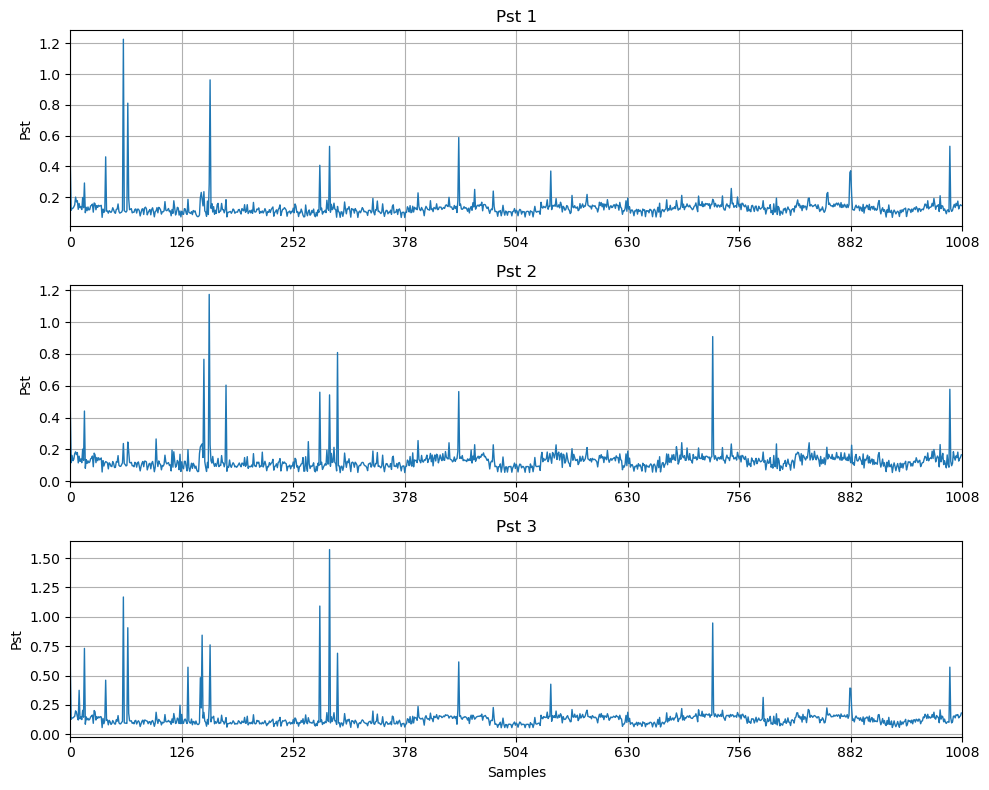

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, sharex=False, figsize=(10, 8)
)

edit_pst_plot(ax1, data_VF["Pst1"], "1")
edit_pst_plot(ax2, data_VF["Pst2"], "2")
edit_pst_plot(ax3, data_VF["Pst3"], "3")

ax3.set_xlabel("Samples")

plt.tight_layout()
plt.show()

# Calculate Percentiles

In [11]:
# Percentis de 95% para Pst instantâneos
p95_pst1 = np.percentile(df['Pst1'], 95)
p95_pst2 = np.percentile(df['Pst2'], 95)
p95_pst3 = np.percentile(df['Pst3'], 95)

[p95_pst1, p95_pst2, p95_pst3]

[np.float64(0.17700999999999997),
 np.float64(0.18220999999999998),
 np.float64(0.18205999999999994)]

# Charts

In [12]:
def plot_lollipop(
    df: pd.DataFrame,
    y_col: str,
    weekday_col: str,
    figsize=(16, 4),
    dpi: int = 300,
    y_lim=(0, 1.6),
    draw_boundaries: bool = True,
    shade_alternating: bool = True,
    constant_line_value: float = None,
    constant_line_label: str = "p95_fd_min",
):
    """
    Plots a lollipop chart and adds a secondary top X-axis
    with weekday intervals defined by another DataFrame column.

    Parameters
    ----------
    constant_line_value : float or None
        If provided, draws a horizontal red line at this value.
    constant_line_label : str or None
        Label shown in the legend for the horizontal line.
    """

    n = len(df)
    if n == 0:
        raise ValueError("Empty DataFrame.")

    # X-axis = sequential sample index
    x = np.arange(n)

    # Y series
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy()

    # Weekday column (as string)
    wd = df[weekday_col].astype(str).to_numpy()

    # --- Base plot (lollipop) ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(x, 0, y, linewidth=0.3)  # thin stems
    ax.scatter(x, y, s=5)              # top points

    ax.set_xlabel("Sample Number", fontsize=16)
    ax.set_ylabel(str(y_col), fontsize=16)

    if y_lim is not None:
        ax.set_ylim(*y_lim)

    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)

    # --- Constant horizontal line (optional) ---
    if constant_line_value is not None:
        ax.axhline(
            y=constant_line_value,
            color="red",
            linewidth=1,
            label=str(constant_line_label) if constant_line_label else None,
        )
        if constant_line_label:
            ax.legend(loc="upper right", fontsize=9, frameon=False)

    # --- Interval calculation (when weekday changes) ---
    if n > 1:
        change_idx = np.where(wd[1:] != wd[:-1])[0] + 1
    else:
        change_idx = np.array([], dtype=int)

    starts = np.r_[0, change_idx]
    ends = np.r_[change_idx, n]
    mids = (starts + ends - 1) / 2.0
    labels = [wd[s] for s in starts]

    # --- Top axis with weekday labels ---
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(mids)
    ax_top.set_xticklabels(labels, fontsize=12)
    ax_top.xaxis.set_ticks_position("top")
    ax_top.tick_params(axis="x", which="both", length=0, pad=6)
    ax_top.set_xlabel("Weekdays", fontsize=16, labelpad=8)

    # Boundary lines between weekdays (optional)
    if draw_boundaries and len(change_idx) > 0:
        for idx in change_idx:
            ax.axvline(idx, linestyle="--", linewidth=0.5, alpha=0.5)

    # Alternating block shading (optional)
    if shade_alternating:
        for i, (s, e) in enumerate(zip(starts, ends)):
            if i % 2 == 0:
                ax.axvspan(s - 0.5, e - 0.5, alpha=0.06)

    plt.tight_layout()
    return fig, ax, ax_top

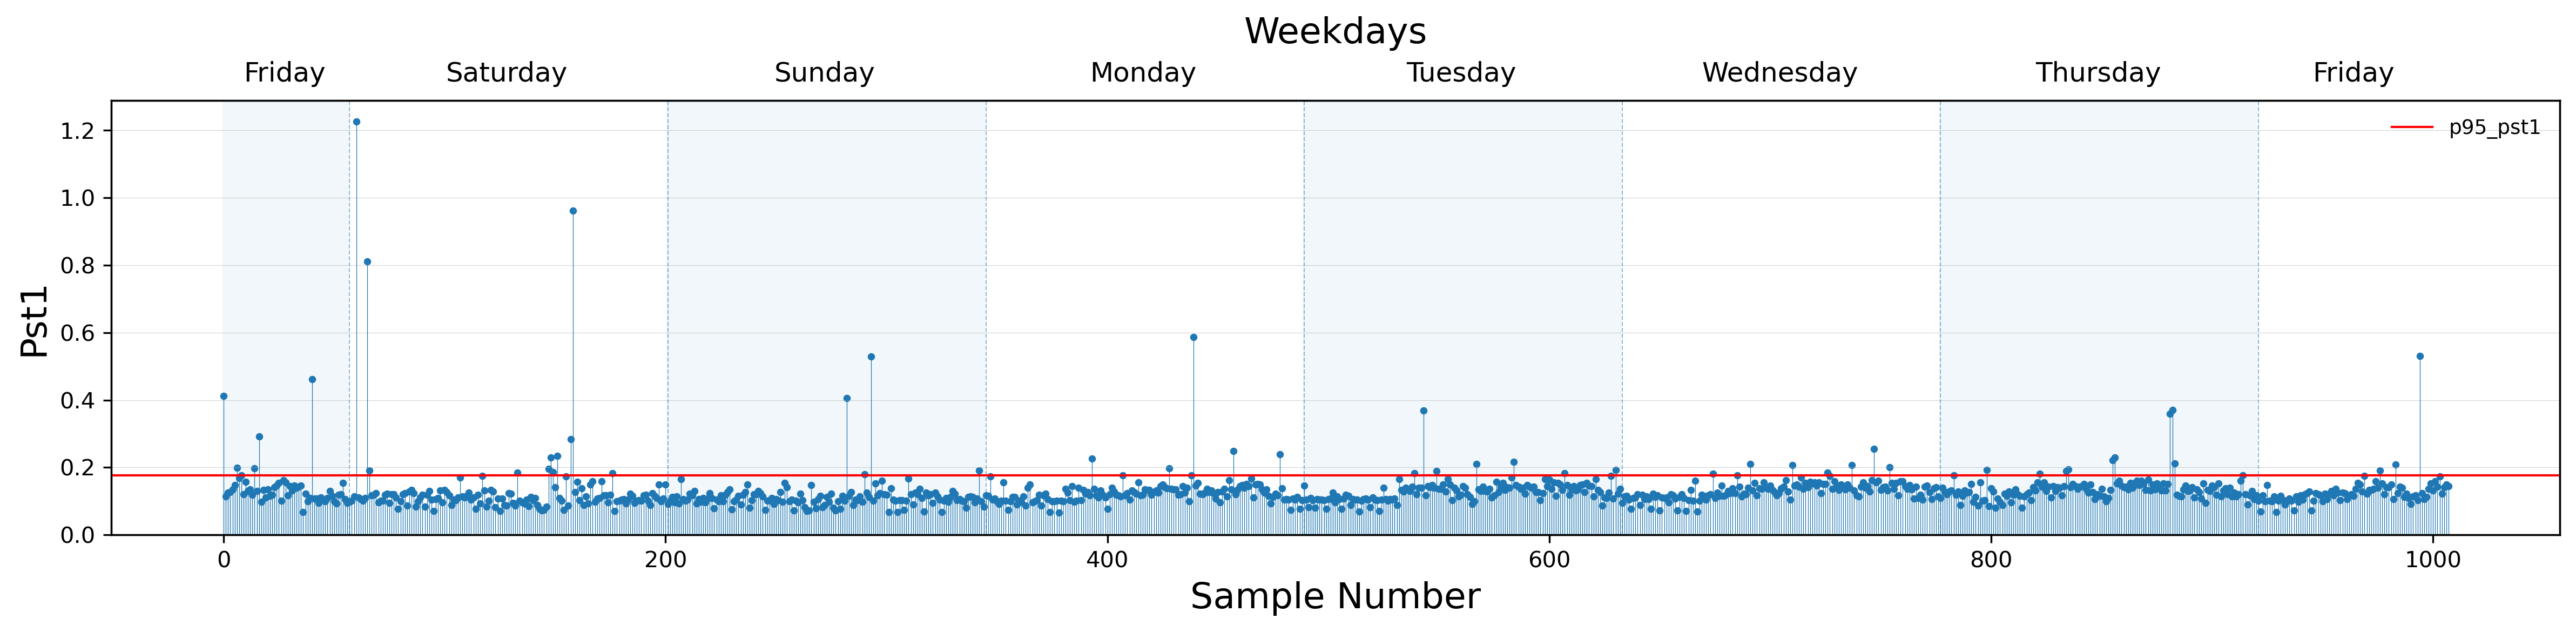

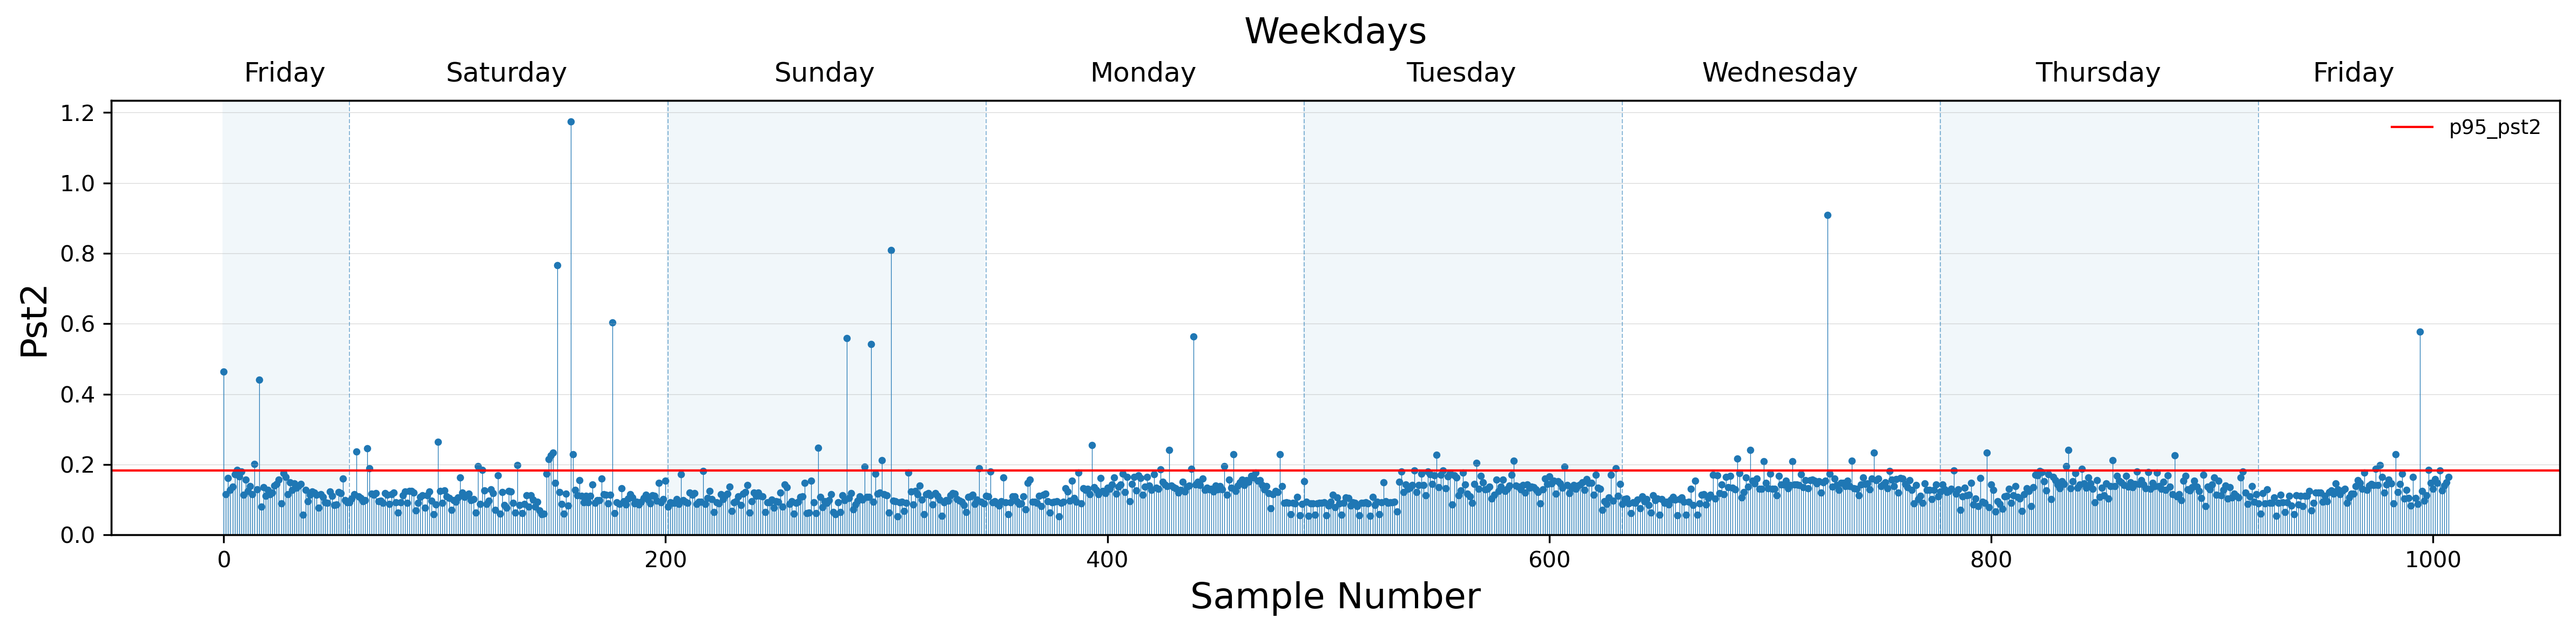

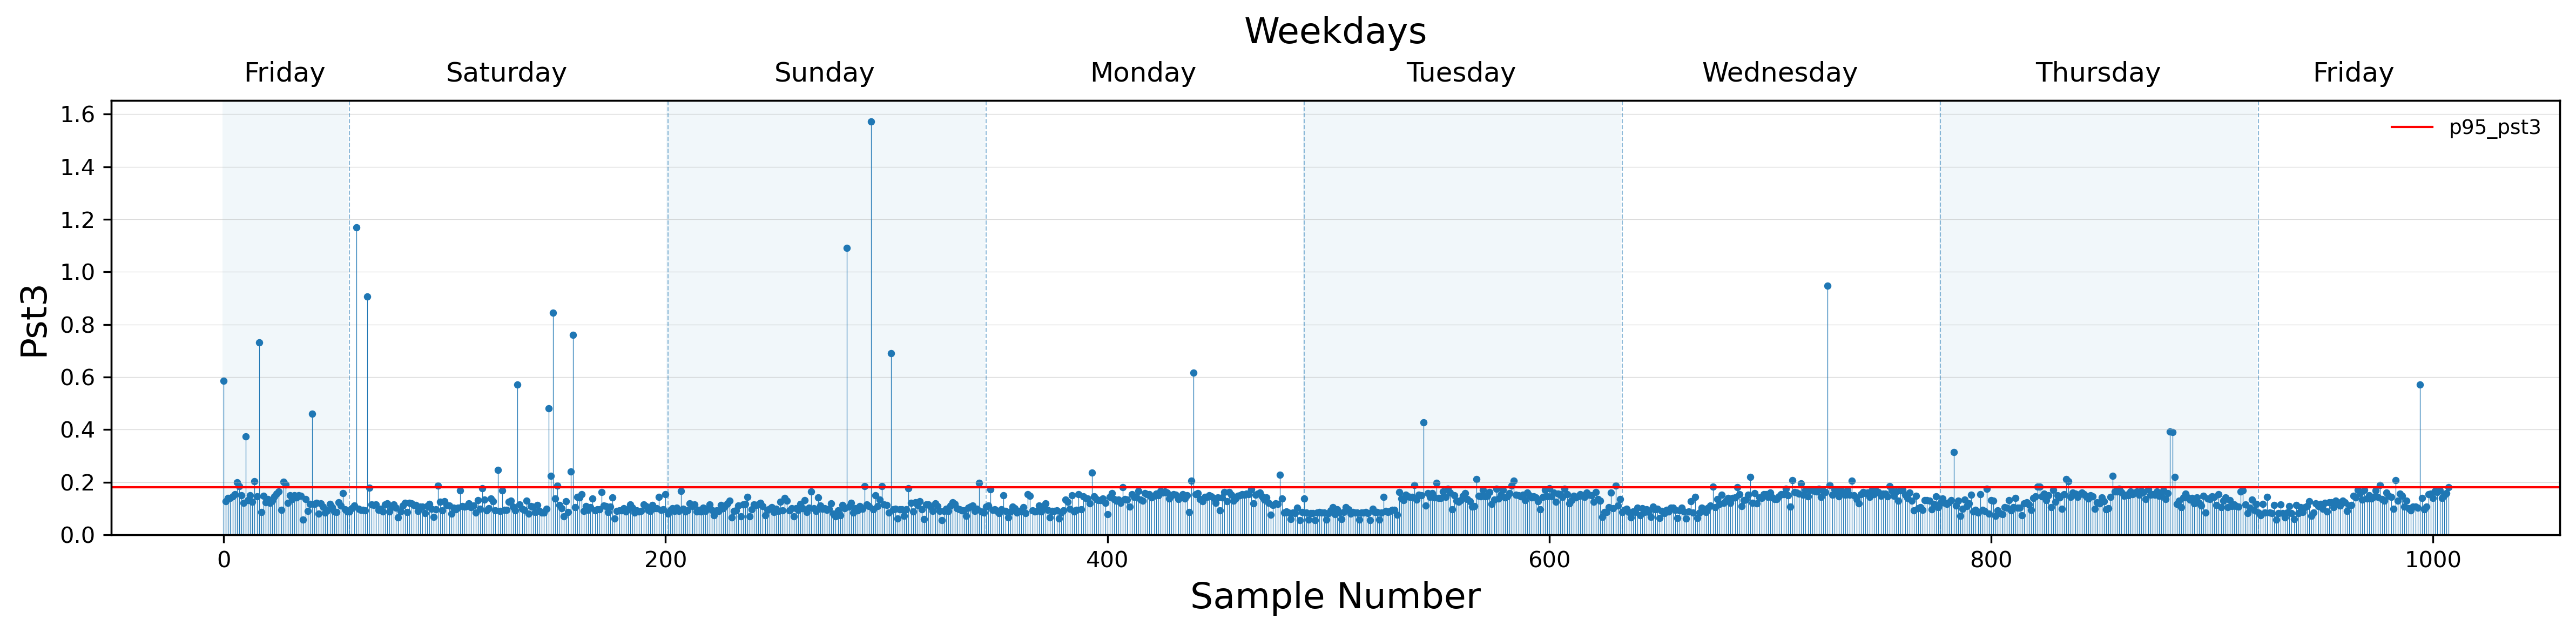

In [13]:
fig = plot_lollipop(data_VF, 'Pst1', 'Weekday_EN', constant_line_value=p95_pst1, constant_line_label="p95_pst1", y_lim = (0, data_VF['Pst1'].max()+ data_VF['Pst1'].max()*0.05))
fig = plot_lollipop(data_VF, 'Pst2', 'Weekday_EN', constant_line_value=p95_pst2, constant_line_label="p95_pst2", y_lim = (0, data_VF['Pst2'].max()+ data_VF['Pst2'].max()*0.05))
fig = plot_lollipop(data_VF, 'Pst3', 'Weekday_EN', constant_line_value=p95_pst3, constant_line_label="p95_pst3", y_lim = (0, data_VF['Pst3'].max()+ data_VF['Pst3'].max()*0.05))
plt.show()

# Pie charts

In [14]:
def create_pie_chart_by_time_type_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Category",
    title_fontsize=16,
    title_pad=10
):

    sns.set_theme(style="white")

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    counts = df.loc[mask, "Time_Type"].value_counts(dropna=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [f"{label} ({pct:.1f}%)" for label, pct in zip(labels, percentages)]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,  # nada dentro da pizza
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by time of day",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': ' | Pst3 > 0.1821 by time of day'}>

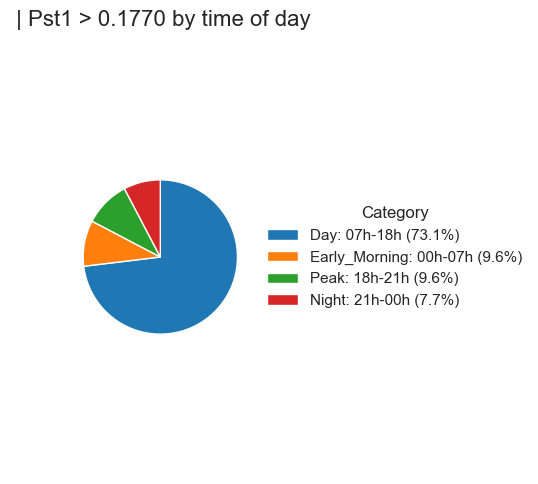

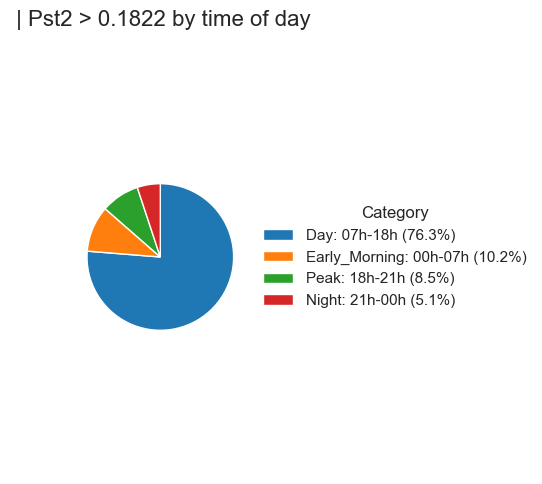

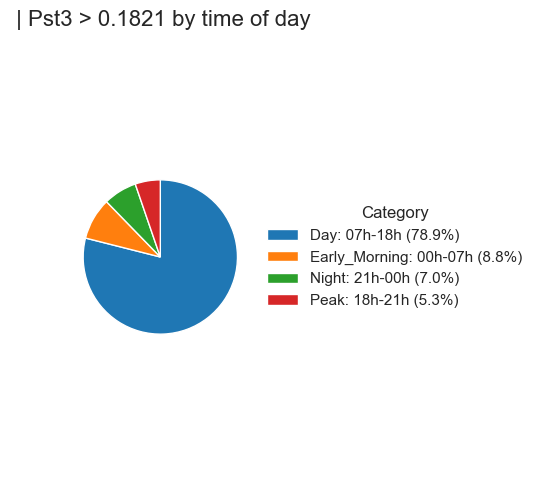

In [15]:
create_pie_chart_by_time_type_sns(data_VF, "Pst1", "flag_Pst1", p95_pst1)
create_pie_chart_by_time_type_sns(data_VF, "Pst2", "flag_Pst2", p95_pst2)
create_pie_chart_by_time_type_sns(data_VF, "Pst3", "flag_Pst3", p95_pst3)

In [16]:
def create_pie_chart_by_weekday_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Weekday",
    title_fontsize=16,
    title_pad=10
):

    sns.set_theme(style="white")

    order = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    s = df.loc[mask, "Weekday_EN"].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    counts = s.value_counts(sort=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [
        f"{label} ({pct:.1f}%)"
        for label, pct in zip(labels, percentages)
    ]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by weekday",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': ' | Pst3 > 0.1821 by weekday'}>

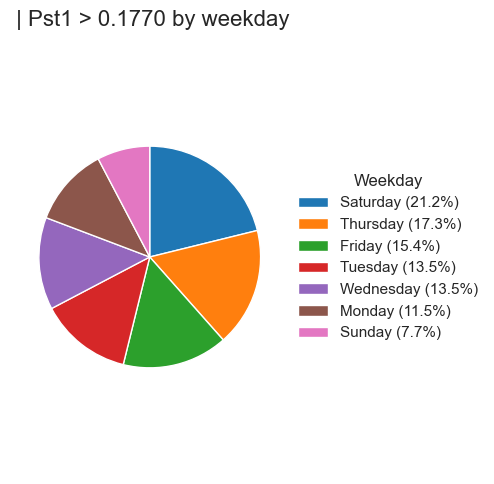

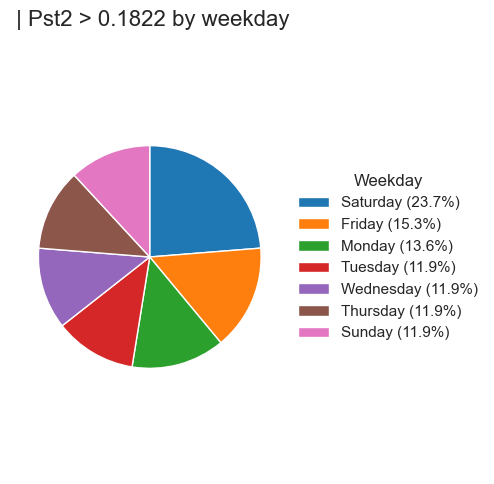

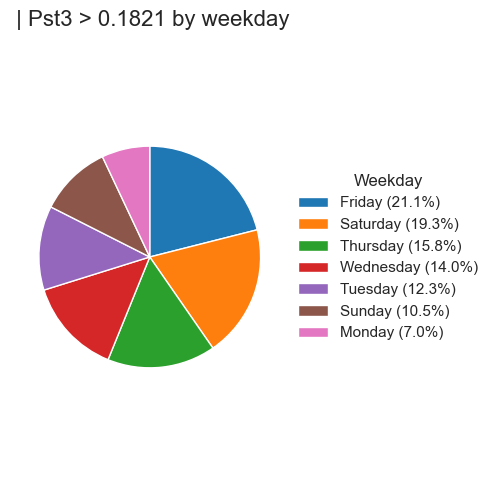

In [17]:
create_pie_chart_by_weekday_sns(data_VF, "Pst1", "flag_Pst1", p95_pst1)
create_pie_chart_by_weekday_sns(data_VF, "Pst2", "flag_Pst2", p95_pst2)
create_pie_chart_by_weekday_sns(data_VF, "Pst3", "flag_Pst3", p95_pst3)